# Empirical Distribution Predictors

We may be losing a lot of information in the annotations by condensing them into a single number. Instead, we can train a model to predict the empirical distribution formed by the annotations over the answer choices. We do this by minimizing the cross-entropy between the predicted distributions and the empirical distributions. This is essentially softmax classification, but off-the-shelf implementations don't let you pass a distribution as a training label, so we have to roll our own in TensorFlow.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from ngram import *
from baselines import *
from error_analysis import *

In [3]:
d = tidy_labels(pd.concat(load_cf_data()))
d = d.dropna(subset=['attack', 'aggression_score'])
d = d.iloc[np.random.permutation(np.arange(d.shape[0]))]

In [14]:
ngram_feature_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), max_features = 5000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
])

In [76]:
training_epochs = 50
batch_size = 500
display_step = 100

# Attack Model: plurality labels

Fit a softmax regression to the most common annotation. 

In [43]:
labels = plurality(d['attack'])

data = get_labeled_comments(d, labels)
train, test = train_test_split(data, test_size = 0.2, random_state=0)

y_train =train.ix[:, train.columns != 'x'].values[:,0]

y_test =test.ix[:, test.columns != 'x'].values[:,0]
y_train = np.array([y_train, 1- y_train]).T
y_test = np.array([y_test, 1- y_test]).T

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Batch: 0001 cost= 3.517418861
Train ROC: 0.429580318592
Test ROC: 0.428008278281
Batch: 0101 cost= 3.274171629
Train ROC: 0.577458829007
Test ROC: 0.572315686618
Batch: 0201 cost= 2.801251857
Train ROC: 0.666560773066
Test ROC: 0.660777070739
Batch: 0301 cost= 2.459870319
Train ROC: 0.716786802287
Test ROC: 0.71141476873
Batch: 0401 cost= 2.181801758
Train ROC: 0.749216141852
Test ROC: 0.744415351113
Batch: 0501 cost= 1.946018354
Train ROC: 0.772491652837
Test ROC: 0.76832199631
Batch: 0601 cost= 1.740121317
Train ROC: 0.790951102936
Test ROC: 0.787277808791
Batch: 0701 cost= 1.564169649
Train ROC: 0.806800410212
Test ROC: 0.803637746449
Batch: 0801 cost= 1.411700967
Train ROC: 0.820710612683
Test ROC: 0.818014723988
Batch: 0901 cost= 1.275168758
Train ROC: 0.832956844784
Test ROC: 0.83070347285
Batch: 1001 cost= 1.156267768
Train ROC: 0.843915418591
Test ROC: 0.842062312932
Batch: 1101 cost= 1.054485549
Train ROC: 0.853863975477
Test ROC: 0.852373205502
Batch: 1201 cost= 0.968011596
T

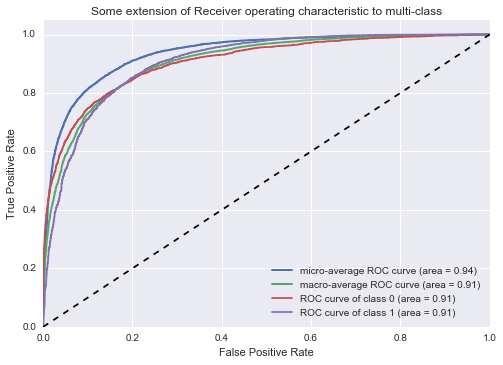

In [75]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

# Attack Model: empirical distribution labels
Fit a softmax regression to the empirical distribtion of annotions over answer choices.

In [88]:
labels = empirical_dist(d['attack'], w = 0.25)
data = get_labeled_comments(d, labels)
train, test = train_test_split(data, test_size = 0.2, random_state=0)

y_train =train.ix[:, train.columns != 'x'].values
y_test =test.ix[:, train.columns != 'x'].values

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Batch: 0001 cost= 3.449808121
Train ROC: 0.467074388114
Test ROC: 0.463647375718
Batch: 0101 cost= 3.188117218
Train ROC: 0.604870244644
Test ROC: 0.60377260293
Batch: 0201 cost= 2.783132787
Train ROC: 0.673523601309
Test ROC: 0.67332882848
Batch: 0301 cost= 2.465838029
Train ROC: 0.70999787885
Test ROC: 0.709980488775
Batch: 0401 cost= 2.197279800
Train ROC: 0.736370147286
Test ROC: 0.736388399108
Batch: 0501 cost= 1.965926290
Train ROC: 0.757388488866
Test ROC: 0.757358530317
Batch: 0601 cost= 1.766506105
Train ROC: 0.776632890835
Test ROC: 0.776505212341
Batch: 0701 cost= 1.594520411
Train ROC: 0.794503481084
Test ROC: 0.794266393748
Batch: 0801 cost= 1.444522708
Train ROC: 0.810133971208
Test ROC: 0.809873633298
Batch: 0901 cost= 1.314805813
Train ROC: 0.825255459757
Test ROC: 0.824976660068
Batch: 1001 cost= 1.202718504
Train ROC: 0.839270309046
Test ROC: 0.838967075308
Batch: 1101 cost= 1.106493866
Train ROC: 0.85203774118
Test ROC: 0.851763295994
Batch: 1201 cost= 1.023557758
Tr

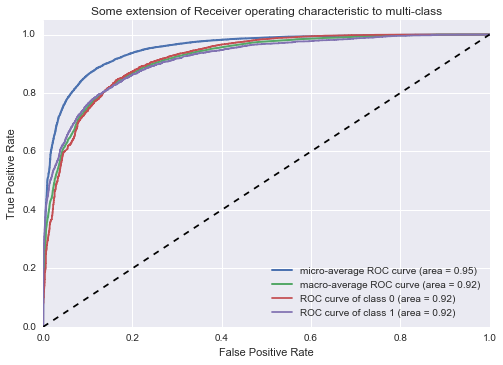

In [89]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

# Agression Model: plurality labels
Fit a softmax regression to the most common annotation. 

In [ ]:
labels = plurality(d['aggression_score'])

data = get_labeled_comments(d, labels)
train, test = train_test_split(data, test_size = 0.2, random_state=0)

m_train  = train.shape[0]
y_train = np.zeros((m_train, 7))
indices =  (train.ix[:, train.columns != 'x'].values[:,0] + 3).astype(int)
y_train[list(range(m_train)), indices] = 1


m_test  = test.shape[0]
y_test = np.zeros((m_test, 7))
indices =  (test.ix[:, test.columns != 'x'].values[:,0] + 3).astype(int)
y_test[list(range(m_test)), indices] = 1

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Batch: 0001 cost= 12.708113670
Train ROC: 0.15383455763
Test ROC: 0.153247476347
Batch: 0101 cost= 11.866609564
Train ROC: 0.186927936132
Test ROC: 0.187470149626
Batch: 0201 cost= 10.293769759
Train ROC: 0.258126768995
Test ROC: 0.261403185752
Batch: 0301 cost= 8.969394556
Train ROC: 0.361069704887
Test ROC: 0.366504421705
Batch: 0401 cost= 7.870879956
Train ROC: 0.461572810164
Test ROC: 0.467867188468
Batch: 0501 cost= 6.965888326
Train ROC: 0.542526600465
Test ROC: 0.54894538621
Batch: 0601 cost= 6.212318132
Train ROC: 0.603827260802
Test ROC: 0.610185188132
Batch: 0701 cost= 5.573994770
Train ROC: 0.650185345091
Test ROC: 0.656452546879
Batch: 0801 cost= 5.031791983
Train ROC: 0.6869193127
Test ROC: 0.693042994216
Batch: 0901 cost= 4.562923695
Train ROC: 0.716468104709
Test ROC: 0.722380262963
Batch: 1001 cost= 4.160438934
Train ROC: 0.741981842319
Test ROC: 0.7476061195
Batch: 1101 cost= 3.816483050
Train ROC: 0.764538270369
Test ROC: 0.76979192658
Batch: 1201 cost= 3.516171350
Tr

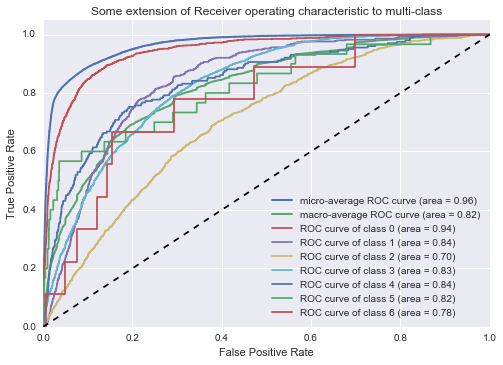

In [85]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

# Agression Model: empirical distribution labels
Fit a softmax regression to the empirical distribtion of annotions over answer choices.

In [90]:
labels = empirical_dist(d['aggression_score'], w = 0.25)
data = get_labeled_comments(d, labels)
train, test = train_test_split(data, test_size = 0.2, random_state=0)

y_train =train.ix[:, train.columns != 'x'].values
y_test =test.ix[:, train.columns != 'x'].values

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Batch: 0001 cost= 11.285729408
Train ROC: 0.502776185415
Test ROC: 0.504790704968
Test Pearson Correlation:  0.0260255701676
Test Spearman Correlation:  0.00812288826425
Batch: 0101 cost= 10.454025665
Train ROC: 0.646259932154
Test ROC: 0.650524544537
Test Pearson Correlation:  0.025036486748
Test Spearman Correlation:  0.0113251702805
Batch: 0201 cost= 9.020619190
Train ROC: 0.74243318625
Test ROC: 0.747334955688
Test Pearson Correlation:  0.0335739664075
Test Spearman Correlation:  0.0206178549461
Batch: 0301 cost= 7.875162754
Train ROC: 0.796145067969
Test ROC: 0.800641322933
Test Pearson Correlation:  0.050695925932
Test Spearman Correlation:  0.0355028367716
Batch: 0401 cost= 6.932245787
Train ROC: 0.828206569841
Test ROC: 0.83207756146
Test Pearson Correlation:  0.0733418845452
Test Spearman Correlation:  0.0537970914824
Batch: 0501 cost= 6.136475896
Train ROC: 0.850060735686
Test ROC: 0.853329727158
Test Pearson Correlation:  0.0988810828648
Test Spearman Correlation:  0.0741258

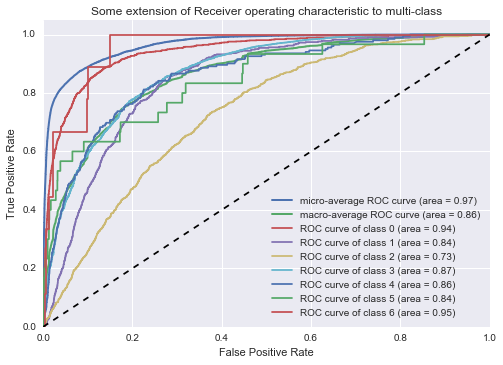

In [99]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)